<a href="https://colab.research.google.com/github/flavioluizseixas/IA-Materno-Infantil/blob/main/AvaliandoModeloDeepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import timm
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Definir caminho do modelo treinado
MODEL_PATH = "model/xception_deepfake.pth"

# Diretórios com as imagens
TEST_DIR = "videos-teste/CELEB-DF/faces"

In [3]:
# Definir transformação das imagens (mesma usada no treinamento)
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception usa 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets

class CustomImageDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        # Obter a imagem e o rótulo normalmente
        path, label = self.samples[index]  # `self.samples` contém os caminhos das imagens
        image = self.loader(path)  # Carregar imagem
        
        # Aplicar transformações
        if self.transform is not None:
            image = self.transform(image)
        
        # Retornar também o nome da imagem
        full_path = os.path.abspath(path)  # Obtém o caminho absoluto do arquivo
        return image, label, full_path  # Retorna a imagem, o rótulo e o nome do arquivo

# Criar dataset personalizado
test_dataset = CustomImageDataset(root=TEST_DIR, transform=transform)

# Criar DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [8]:
# Carregar modelo treinado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("xception41.tf_in1k", pretrained=False, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

XceptionAligned(
  (stem): Sequential(
    (0): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
  )
  (blocks): Sequential(
    (0): XceptionModule(
      (shortcut): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (stack): Sequential(
     

In [ ]:
# Fazer inferência
all_preds = []
all_labels = []
image_names = []

with torch.no_grad():
    for images, labels, filenames in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        image_names.extend(filenames)  # Salvar os nomes das imagens

In [23]:
import pandas as pd

# Criar um DataFrame com os resultados das predições
df_results = pd.DataFrame({
    "Image Name": image_names,   # Lista com os nomes das imagens
    "True Label": all_labels,    # Lista com os rótulos verdadeiros
    "Predicted Label": all_preds # Lista com os rótulos preditos pelo modelo
})


import pickle

with open("evaluate-data.pkl", "wb") as f:
    pickle.dump((all_preds, all_labels, image_names, df_results), f)


# Salvar o DataFrame em um arquivo Excel
excel_path = "deepfake_detection_results.xlsx"
df_results.to_excel(excel_path, index=False)

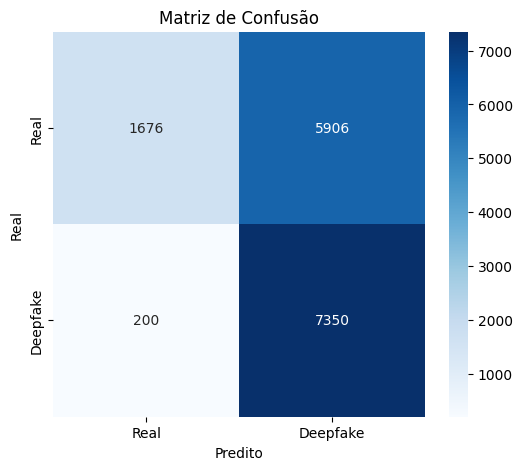

              precision    recall  f1-score   support

        Real       0.89      0.22      0.35      7582
    Deepfake       0.55      0.97      0.71      7550

    accuracy                           0.60     15132
   macro avg       0.72      0.60      0.53     15132
weighted avg       0.72      0.60      0.53     15132



In [20]:
# Criar matriz de confusão
cm = confusion_matrix(all_labels, all_preds)
labels = ["Real", "Deepfake"]

# Exibir matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Exibir relatório de classificação
print(classification_report(all_labels, all_preds, target_names=labels))